In [3]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL

import tensorflow as tf

# import tensorflow.compat.v1 as tf 
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 


In [4]:
import pathlib

from matplotlib.path import Path

data_dir = pathlib.Path('cell_images/')

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27538


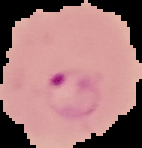

In [6]:
malaria = list(data_dir.glob('parasitized/*'))
PIL.Image.open(str(malaria[0]))


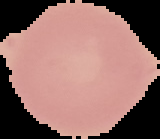

In [7]:
healthy = list(data_dir.glob('uninfected/*'))
PIL.Image.open(str(healthy[0]))


In [8]:
batch_size = 32
img_height = 120
img_width = 120

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 27538 files belonging to 2 classes.
Using 22031 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 27538 files belonging to 2 classes.
Using 5507 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)


['Parasitized', 'Uninfected']


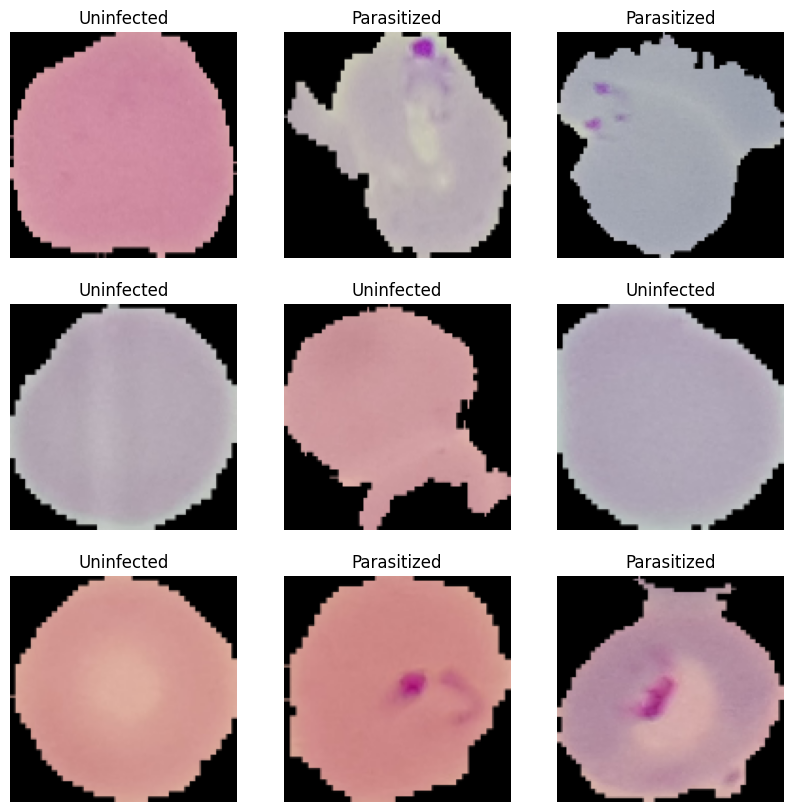

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 120, 120, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)


In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.88192815


In [17]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28800)             0

In [20]:
epochs = 5
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
689/689 [==============================] - 67s 97ms/step - loss: 0.3788 - accuracy: 0.8277 - val_loss: 0.2320 - val_accuracy: 0.9150
Epoch 2/5
689/689 [==============================] - 62s 90ms/step - loss: 0.1942 - accuracy: 0.9304 - val_loss: 0.1841 - val_accuracy: 0.9383
Epoch 3/5
689/689 [==============================] - 62s 90ms/step - loss: 0.1554 - accuracy: 0.9449 - val_loss: 0.1725 - val_accuracy: 0.9390
Epoch 4/5
689/689 [==============================] - 63s 91ms/step - loss: 0.1259 - accuracy: 0.9549 - val_loss: 0.1627 - val_accuracy: 0.9464
Epoch 5/5
689/689 [==============================] - 63s 92ms/step - loss: 0.0979 - accuracy: 0.9662 - val_loss: 0.2409 - val_accuracy: 0.9285


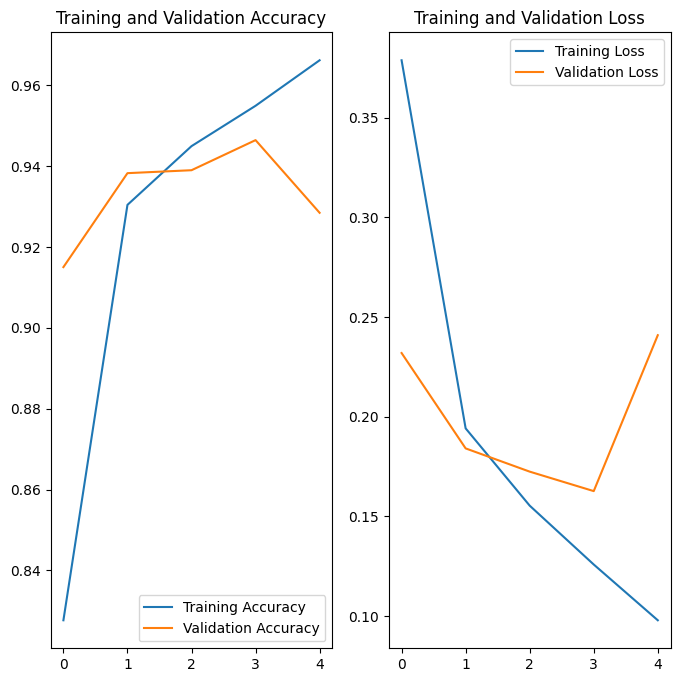

In [25]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
num_classes = len(class_names)

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)       

In [29]:
epochs = 5
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
689/689 [==============================] - 77s 111ms/step - loss: 0.3255 - accuracy: 0.8508 - val_loss: 0.1682 - val_accuracy: 0.9468
Epoch 2/5
689/689 [==============================] - 75s 109ms/step - loss: 0.1536 - accuracy: 0.9508 - val_loss: 0.1376 - val_accuracy: 0.9541
Epoch 3/5
689/689 [==============================] - 75s 109ms/step - loss: 0.1288 - accuracy: 0.9581 - val_loss: 0.1288 - val_accuracy: 0.9571
Epoch 4/5
689/689 [==============================] - 75s 109ms/step - loss: 0.1073 - accuracy: 0.9641 - val_loss: 0.1311 - val_accuracy: 0.9539
Epoch 5/5
689/689 [==============================] - 75s 109ms/step - loss: 0.0899 - accuracy: 0.9693 - val_loss: 0.1382 - val_accuracy: 0.9575


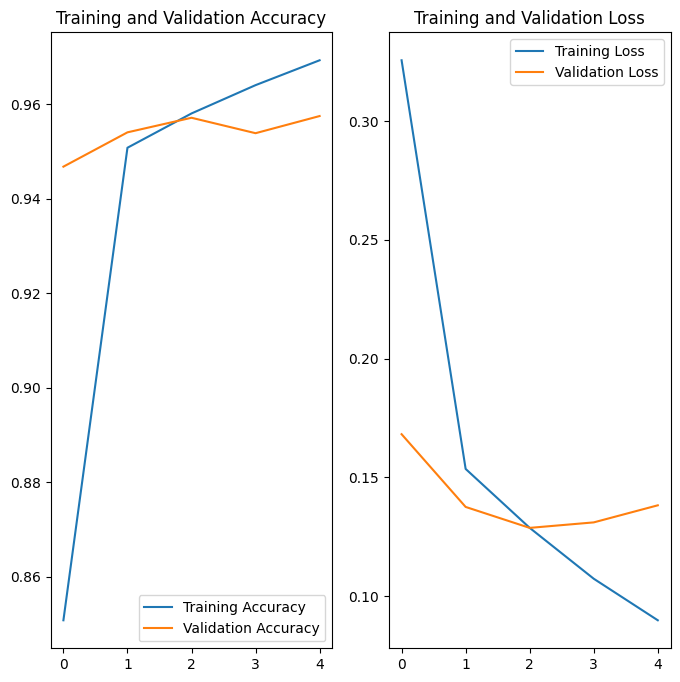

In [30]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

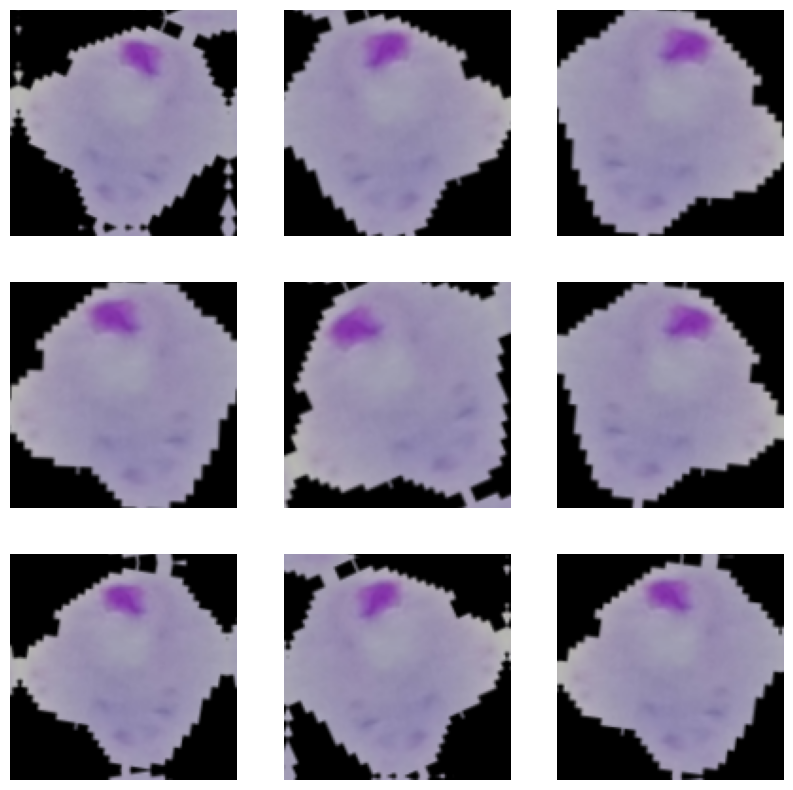

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [33]:
model3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [34]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

In [36]:
epochs = 10
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
689/689 [==============================] - 94s 132ms/step - loss: 0.3778 - accuracy: 0.8123 - val_loss: 0.2017 - val_accuracy: 0.9167
Epoch 2/10
689/689 [==============================] - 91s 132ms/step - loss: 0.1728 - accuracy: 0.9453 - val_loss: 0.1420 - val_accuracy: 0.9542
Epoch 3/10
689/689 [==============================] - 91s 131ms/step - loss: 0.1503 - accuracy: 0.9528 - val_loss: 0.1497 - val_accuracy: 0.9508
Epoch 4/10
689/689 [==============================] - 91s 132ms/step - loss: 0.1413 - accuracy: 0.9555 - val_loss: 0.1282 - val_accuracy: 0.9570
Epoch 5/10
689/689 [==============================] - 91s 132ms/step - loss: 0.1382 - accuracy: 0.9554 - val_loss: 0.1260 - val_accuracy: 0.9586
Epoch 6/10
689/689 [==============================] - 90s 131ms/step - loss: 0.1292 - accuracy: 0.9576 - val_loss: 0.1371 - val_accuracy: 0.9550
Epoch 7/10
689/689 [==============================] - 91s 132ms/step - loss: 0.1272 - accuracy: 0.9581 - val_loss: 0.1262 - val_ac

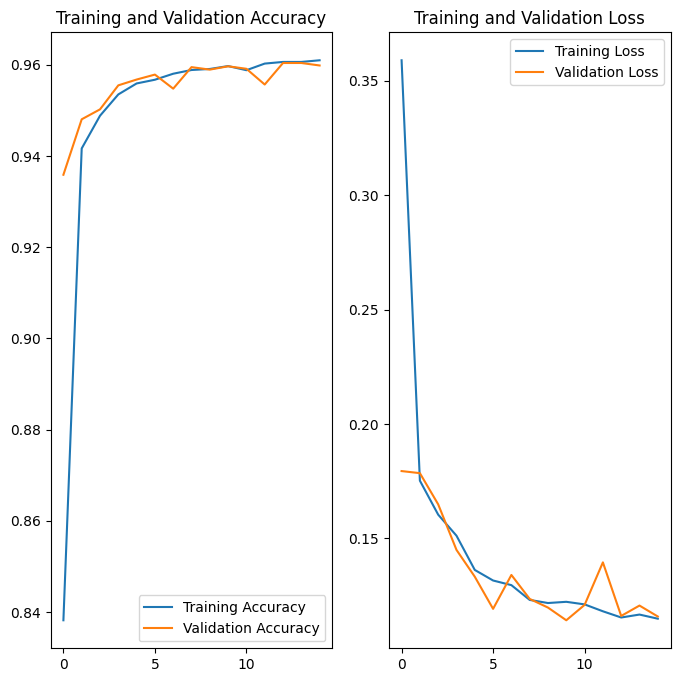

In [26]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


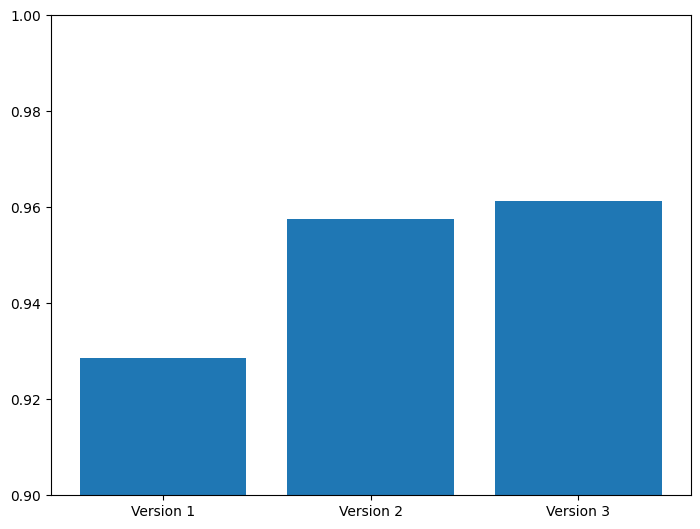

In [41]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
versions = ['Version 1', 'Version 2', 'Version 3']
students = [0.9285, 0.9575, 0.9613]
ax.bar(versions,students)
ax.set_ylim([0.9, 1.0])
plt.show()

In [35]:
model.save('saved_model/malaria_96.h5')

In [47]:
img_name = "C241NThinF_IMG_20151207_124643_cell_158.png"

path = 'test/'+img_name

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 18ms/step
This image most likely belongs to Uninfected with a 98.44 percent confidence.


In [36]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\gohlk\AppData\Local\Temp\tmpjnisoatf\assets


INFO:tensorflow:Assets written to: C:\Users\gohlk\AppData\Local\Temp\tmpjnisoatf\assets


In [37]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [38]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [39]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [57]:
img_name = "C119P80ThinF_IMG_20151002_122720_cell_160.png"

path = 'test/'+img_name

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

# assert np.allclose(predictions, predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)


This image most likely belongs to Parasitized with a 98.82 percent confidence.
